In [1]:
import sys 
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
class TmpAgent(EstimationAgent): ###fastslam2fastslamagent
    def decision(self, observation):
        return super().decision([])

<IPython.core.display.Javascript object>


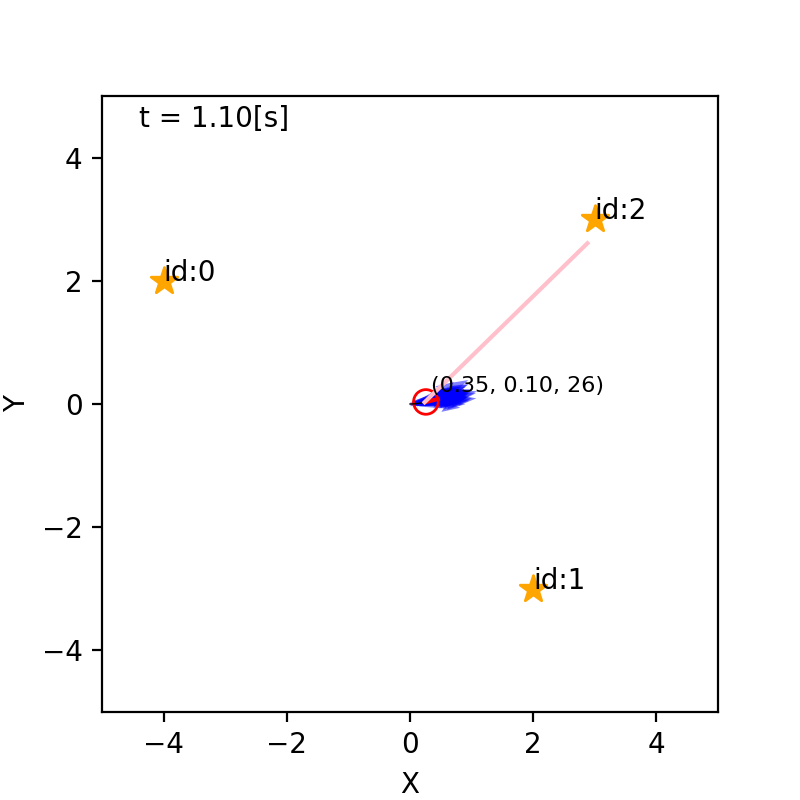

In [3]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = Mcl(None, init_pose, 100) #地図にはとりあえずNoneを
    circling = TmpAgent(time_interval, 0.2, 10.0/180*math.pi, pf)#envmapをlandmark_numに入れ替え
    r = Robot(init_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)

    world.draw()